In [2]:
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM, BatchNormalization, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import time

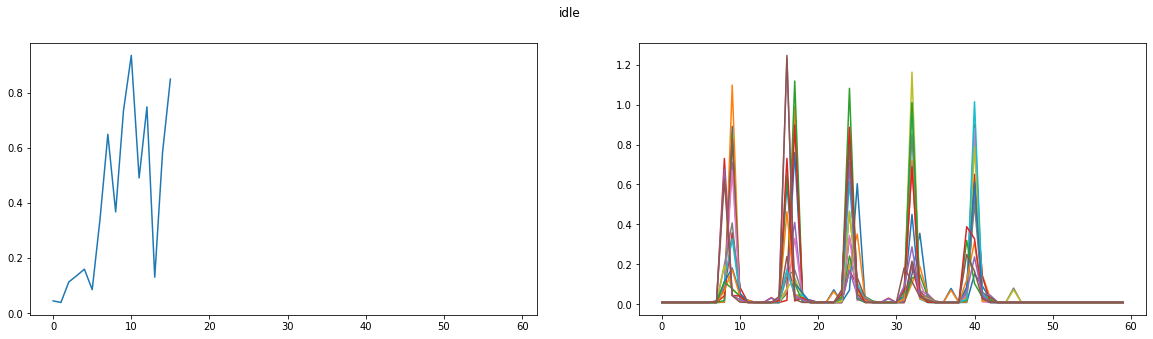

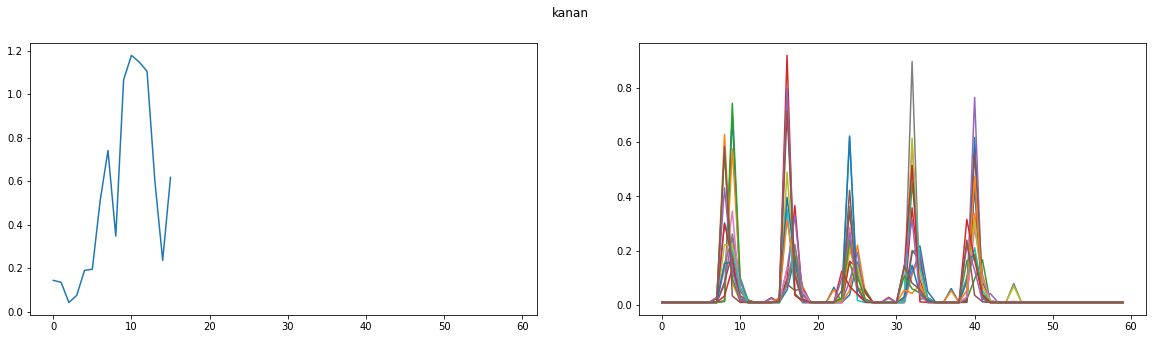

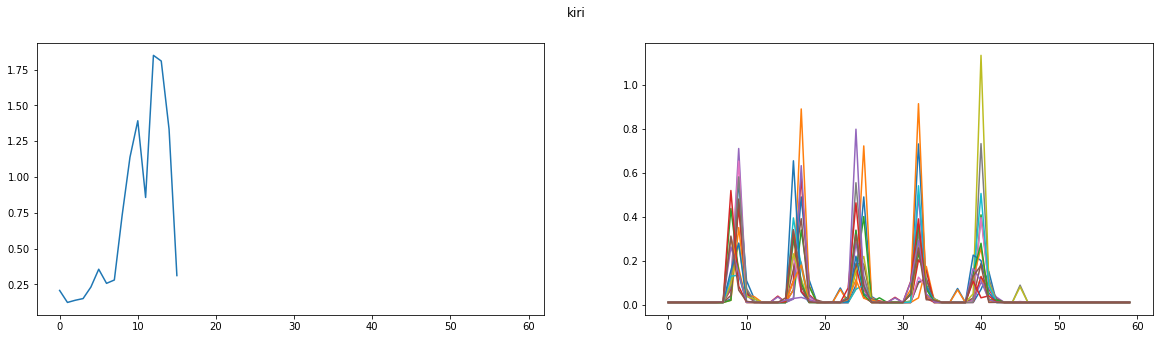

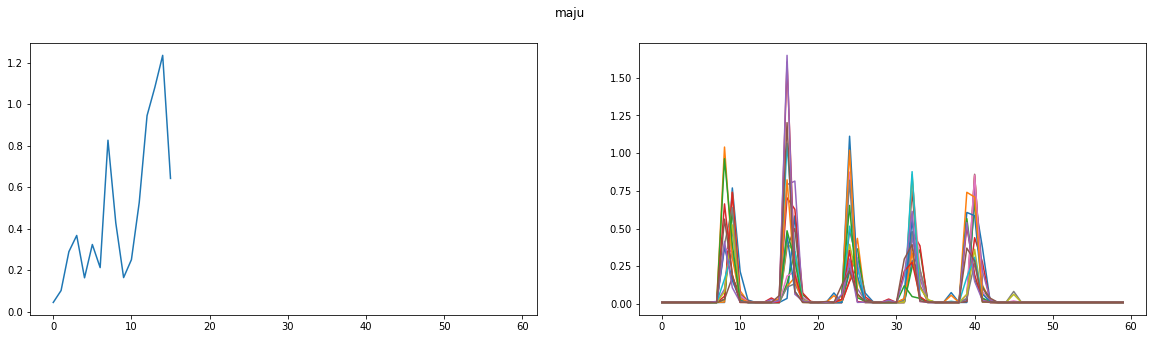

In [3]:
idle = np.load("data_baru\\idle\\1604315006.npy")
kanan = np.load("data_baru\\kanan\\1604315180.npy")
kiri = np.load("data_baru\\kiri\\1604315126.npy")
maju = np.load("data_baru\\maju\\1604315069.npy")

fig, (ax1, ax2) =  plt.subplots( ncols=2, sharex=True,figsize=(20, 5))
fig.suptitle('idle')
ax1.plot(idle[0][16])
ax2.plot(idle[175])

fig, (ax3, ax4) =  plt.subplots( ncols=2, sharex=True,figsize=(20, 5))
fig.suptitle('kanan')
ax3.plot(kanan[0][16])
ax4.plot(kanan[175])

fig, (ax5, ax6) =  plt.subplots( ncols=2, sharex=True,figsize=(20, 5))
fig.suptitle('kiri')
ax5.plot(kiri[0][16])
ax6.plot(kiri[175])

fig, (ax7, ax8) =  plt.subplots( ncols=2, sharex=True,figsize=(20, 5))
fig.suptitle('maju')
ax7.plot(maju[0][16])
ax8.plot(maju[175])



plt.show()

In [4]:
ACTIONS = ["kiri", "maju","idle","kanan"]
reshape = (-1,16, 60,1)


def create_data(starting_dir="=data"):
    training_data = {}
    for action in ACTIONS:
        if action not in training_data:
            training_data[action] = []
        data_dir = os.path.join(starting_dir,action)
        for item in os.listdir(data_dir):
            data = np.load(os.path.join(data_dir, item))
            for item in data:
                training_data[action].append(item)

    lengths = [len(training_data[action]) for action in ACTIONS]
    print(lengths)

    for action in ACTIONS:
        np.random.shuffle(training_data[action])  
        training_data[action] = training_data[action][:min(lengths)]

    lengths = [len(training_data[action]) for action in ACTIONS]
    print(lengths)
    combined_data = []
    for action in ACTIONS:
        for data in training_data[action]:
            if action == "kiri":
                combined_data.append([data, [1, 0, 0,0]])
            elif action == "maju":
                combined_data.append([data, [0, 1, 0, 0]])
            elif action == "idle":
                combined_data.append([data, [0, 0, 1, 0]])
            elif action == "kanan":
                combined_data.append([data, [0, 0, 0, 1]])

    np.random.shuffle(combined_data)
    print("length:",len(combined_data))
    return combined_data


In [5]:
print("creating training data")
traindata = create_data(starting_dir="data_baru")
train_X = []
train_y = []
for X, y in traindata:
    train_X.append(X)
    train_y.append(y)



creating training data
[1000, 1000, 1000, 1000]
[1000, 1000, 1000, 1000]
length: 4000


In [6]:
print("creating testing data")
testdata = create_data(starting_dir="data_baru")
test_X = []
test_y = []
for X, y in testdata:
    test_X.append(X)
    test_y.append(y)
print(len(train_X))
print(len(test_X))
print(np.array(train_X).shape)


train_X = np.array(train_X).reshape(reshape)
test_X = np.array(test_X).reshape(reshape)

train_y = np.array(train_y)
test_y = np.array(test_y)




creating testing data
[1000, 1000, 1000, 1000]
[1000, 1000, 1000, 1000]
length: 4000
4000
4000
(4000, 60, 16)


In [7]:

model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (7,7), padding = "same", activation = "relu", input_shape=train_X.shape[1:]))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size = (3,3)))
model.add(Conv2D(filters = 64, kernel_size = (5,5), padding = "same", activation = "relu",input_shape=train_X.shape[1:]))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size = (3,3)))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu",input_shape=train_X.shape[1:]))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size = (3,3)))
model.add(Flatten())
#model.add(Dropout(0.2))
model.add(Dense(32, activation = "relu"))
model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(4, activation = "sigmoid"))

adam = Adam(lr = 0.0001)
model.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ['accuracy','mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 60, 64)        3200      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 60, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 60, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 60, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 60, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 60, 64)        256       
_________________________________________________________________
flatten (Flatten)            (None, 61440)             0

In [8]:
epochs = 100
batch_size = 32

history = model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, validation_data=(test_X, test_y))
score = model.evaluate(test_X, test_y, batch_size=batch_size)
MODEL_NAME = f"CNN_model/{round(score[1]*100,2)}-acc-64x3-batch-norm-{epochs}epoch-{int(time.time())}-loss-{round(score[0],2)}.model"
model.save(MODEL_NAME)




Epoch 1/100
125/125 [==============================] - 16s 131ms/step - loss: 0.7141 - accuracy: 0.3000 - mse: 0.2560 - val_loss: 0.7581 - val_accuracy: 0.2542 - val_mse: 0.2818
Epoch 2/100
125/125 [==============================] - 16s 130ms/step - loss: 0.6320 - accuracy: 0.4457 - mse: 0.2212 - val_loss: 0.8869 - val_accuracy: 0.2625 - val_mse: 0.3294
Epoch 3/100
125/125 [==============================] - 16s 128ms/step - loss: 0.5679 - accuracy: 0.5630 - mse: 0.1940 - val_loss: 1.1198 - val_accuracy: 0.2820 - val_mse: 0.3864
Epoch 4/100
125/125 [==============================] - 16s 128ms/step - loss: 0.4906 - accuracy: 0.6708 - mse: 0.1624 - val_loss: 1.4695 - val_accuracy: 0.3325 - val_mse: 0.4336
Epoch 5/100
125/125 [==============================] - 16s 128ms/step - loss: 0.4341 - accuracy: 0.7272 - mse: 0.1396 - val_loss: 1.1073 - val_accuracy: 0.3957 - val_mse: 0.3495
Epoch 6/100
125/125 [==============================] - 16s 128ms/step - loss: 0.3849 - accuracy: 0.7595 - mse:

KeyboardInterrupt: 

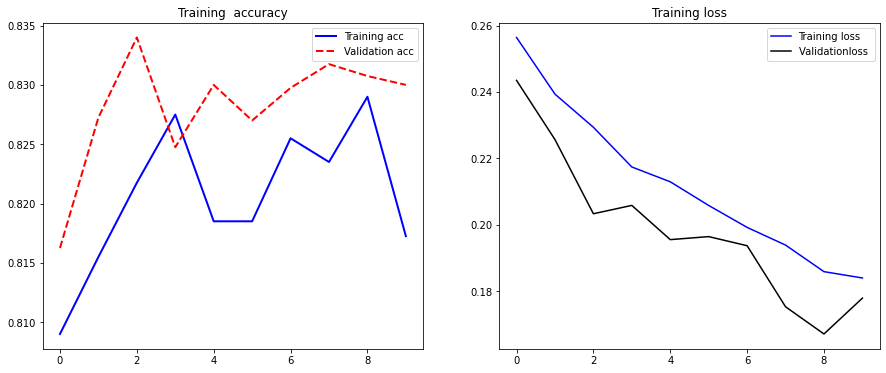

In [9]:


def plot_training_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
 
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc',linewidth=2)
    plt.plot(epochs, val_acc, 'r--', label='Validation acc',linewidth=2)
    plt.title('Training  accuracy')
    plt.legend()
 
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'k', label='Validationloss ')
    plt.title('Training loss')
    plt.legend()
 
    plt.show()
plot_training_history(history)

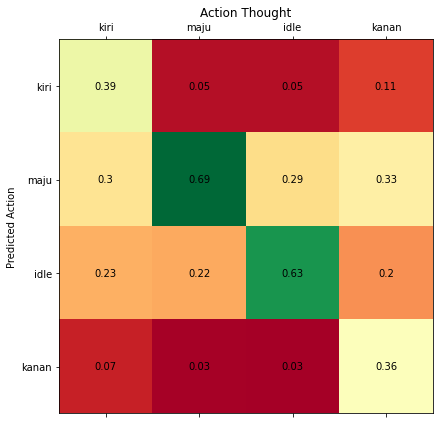

In [22]:
MODEL_NAME = MODEL_NAME
CLIP = True  # if your model was trained with np.clip to clip  values
CLIP_VAL = 10  # if above, what was the value +/-

model = tf.keras.models.load_model(MODEL_NAME)

VALDIR = 'data_baru'
ACTIONS =  ["kiri", "maju","idle","kanan"]
PRED_BATCH = 32


def get_val_data(valdir, action, batch_size):

    argmax_dict = {0: 0, 1: 0, 2: 0,3:0}
    raw_pred_dict = {0: 0, 1: 0, 2: 0,3:0}

    action_dir = os.path.join(valdir, action)
    for session_file in os.listdir(action_dir):
        filepath = os.path.join(action_dir,session_file)
        if CLIP:
            data = np.clip(np.load(filepath), -CLIP_VAL, CLIP_VAL) / CLIP_VAL
        else:
            data = np.load(filepath) 
        preds = model.predict([data.reshape(-1, 16, 60,1)], batch_size=batch_size)

        for pred in preds:
            argmax = np.argmax(pred)
            argmax_dict[argmax] += 1
            for idx,value in enumerate(pred):
                raw_pred_dict[idx] += value

    argmax_pct_dict = {}

    for i in argmax_dict:
        total = 0
        correct = argmax_dict[i]
        for ii in argmax_dict:
            total += argmax_dict[ii]
        argmax_pct_dict[i] = round(correct/total, 4)
    return argmax_dict, raw_pred_dict, argmax_pct_dict


def make_conf_mat(left,forward, none, right):
    action_dict = {"kiri": left, "maju": forward, "idle":none,"kanan": right}
    action_conf_mat = pd.DataFrame(action_dict)
    actions = [i for i in action_dict]

    fig = plt.figure(figsize=(15, 6))
   
    ax = fig.add_subplot(111)
    
    ax.matshow(action_conf_mat, cmap=plt.cm.RdYlGn)
    ax.set_xticklabels([""]+actions)
    ax.set_yticklabels([""]+actions)

    #print("__________")
    #print(action_dict)
    for idx, i in enumerate(action_dict):
        #print('tf',i)
        for idx2, ii in enumerate(action_dict[i]):
            #print(i, ii)
            #print(action_dict[i][ii])
            ax.text(idx, idx2, f"{round(float(action_dict[i][ii]),2)}", va='center', ha='center')
    # Rotate the tick labels and set their alignment.
    
    plt.title("Action Thought")
    plt.ylabel("Predicted Action")
    fig.tight_layout()
    plt.show()


left_argmax_dict, left_raw_pred_dict, left_argmax_pct_dict = get_val_data(VALDIR, "kiri", PRED_BATCH)
forward_argmax_dict, forward_raw_pred_dict, forward_argmax_pct_dict = get_val_data(VALDIR, "maju", PRED_BATCH)
none_argmax_dict, none_raw_pred_dict, none_argmax_pct_dict = get_val_data(VALDIR, "idle", PRED_BATCH)
right_argmax_dict, right_raw_pred_dict, right_argmax_pct_dict = get_val_data(VALDIR, "kanan", PRED_BATCH)
make_conf_mat(left_argmax_pct_dict,forward_argmax_pct_dict, none_argmax_pct_dict, right_argmax_pct_dict)